**1**. **Importing Required Modules**

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist # Import the mnist object from Keras


In [ ]:


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))  # Use Input instead of layer.input
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) # Use Conv2D instead of layer.conv2D
x = MaxPooling2D((2, 2), padding='same')(x) # Use MaxPooling2D instead of layer.maxpooling2D, and remove activation='relu' from MaxPooling2D
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # Use MaxPooling2D instead of layer.maxpooling2D, and remove activation='relu' from MaxPooling2D
# decoding
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# building the autoencoder model
autoencoder = Model(input_img, decoded) # Use Model instead of model.model
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit (x_train,x_train,epochs=3,batch_size=128,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 124s 258ms/step - loss: 0.6989 - val_loss: 0.6952
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 253ms/step - loss: 0.6938 - val_loss: 0.6894
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 254ms/step - loss: 0.6876 - val_loss: 0.6815


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


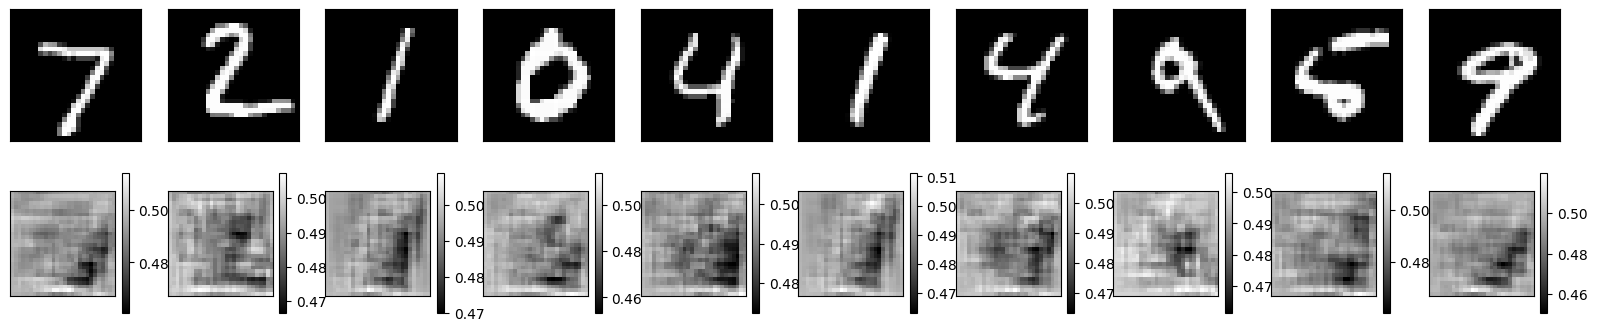

In [ ]:
encoded_imgs = autoencoder.predict(x_test)
#display the result
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
class Autoencoder:
    """
    Autoencoder represents a Deep Convolutional autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None

        self._build()

    def summary(self):
        self.encoder.summary()

    def _build(self):
        self._build_encoder()
        #self._build_decoder()
        #self._build_autoencoder()

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck (Dense layer)."""
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        return x


if __name__ == "__main__":
    autoencoder = Autoencoder(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_1 (Conv2D)        │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_1 (ReLU)                │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_1 (BatchNormalization)    │ (None, 28, 28, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_2 (Conv2D)        │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_3 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_3 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_3 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_4 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_4 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_4 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)